In [1]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"



Cloning into 'deepflows'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 326 (delta 17), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (326/326), 3.21 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=b0a53322787178c8efb14411ab4dc57920a5d66996a1034426dff74fdc80962b
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5rwa1cw/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc
  Found existing installation: recurrent-flows-msc 0.1.0
    Uninstalling recurrent-flows-msc-0.1.0:
      Successfully uninstalled recurrent-flows-msc-0.1.0


In [2]:
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td
import gzip
import math
import numpy as np
import os
from PIL import Image
import random
import torch
import torch.utils.data as data

device = utils.set_gpu(True, verbose=True)


Device set to:  cuda


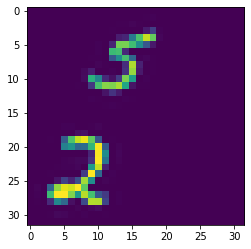

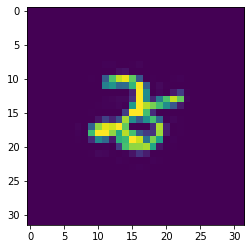

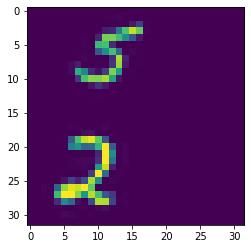

In [3]:
import socket
import numpy as np
from torchvision import datasets, transforms

class MovingMNIST(object):
    
    """Data Handler that creates Bouncing MNIST dataset on the fly."""

    def __init__(self, train, data_root, seq_len=20, num_digits=2, image_size=32,digit_size=28, deterministic=True, three_channels = True, step_length=4, normalize = True, make_target = False):
        path = data_root
        self.seq_len = seq_len
        self.num_digits = num_digits  
        self.image_size = image_size 
        self.step_length = step_length
        self.digit_size = digit_size
        self.deterministic = deterministic
        self.seed_is_set = False # multi threaded loading
        self.channels = 1 
        self.three_channels = three_channels
        self.normalize = normalize
        self.make_target = make_target
        self.data = datasets.MNIST(
                path,
                train=train,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(self.digit_size, interpolation=1),
                     transforms.ToTensor()]))

        self.N = len(self.data) 

    def set_seed(self, seed):
        if not self.seed_is_set:
            self.seed_is_set = True
            np.random.seed(seed)
          
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        self.set_seed(index)
        image_size = self.image_size
        digit_size = self.digit_size
       
        x = np.zeros((self.seq_len,
                          image_size, 
                          image_size, 
                          self.channels),
                        dtype=np.float32)
        
        for n in range(self.num_digits):
            idx = np.random.randint(self.N)
            digit, _ = self.data[idx]
            digit=digit.numpy()
            ds=digit.shape[1]
            sx = np.random.randint(image_size-ds)
            sy = np.random.randint(image_size-ds)
            dx = np.random.randint(-self.step_length, self.step_length+1)
            dy = np.random.randint(-self.step_length, self.step_length+1)
            for t in range(self.seq_len):
                if sy < 0:
                    sy = 0 
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(1, self.step_length+1)
                        dx = np.random.randint(-self.step_length, self.step_length+1)
                elif sy >= image_size-ds:
                    sy = image_size-ds-1
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(-self.step_length, 0)
                        dx = np.random.randint(-self.step_length, self.step_length+1)
                    
                if sx < 0:
                    sx = 0 
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(1, self.step_length+1)
                        dy = np.random.randint(-self.step_length, self.step_length+1)
                elif sx >= image_size-ds:
                    sx = image_size-ds-1
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(-self.step_length, 0)
                        dy = np.random.randint(-self.step_length, self.step_length+1)
                   
                x[t, sy:sy+ds, sx:sx+ds, 0] += digit.squeeze()
                sy += dy
                sx += dx
                

        if self.normalize:
          x = (x - 0.1307) / 0.3081
        
        n_channels = 1
        x=x.reshape(self.seq_len, n_channels, self.image_size, self.image_size)
        x[x>1] = 1. # When the digits are overlapping.
        
        if self.three_channels:
            x=np.repeat(x, 3, axis=1)
        
        if self.make_target == True:
          # splits data into two, a one for training and another one for target, output will be a LIST with 2 elements 
          x = np.split(x, 2, axis=0)
        return x

n_frames = 20
testset = MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=32, digit_size=14, num_digits=2, 
                                            deterministic=True, three_channels=False, step_length=2, normalize=False, make_target = True)
trainset = MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size = 32, digit_size = 14, num_digits=2, 
                                              deterministic=True, three_channels=False, step_length=2, normalize=False, make_target = True)
batch_size = 32
train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)

input, target = next(iter(train_loader))
plt.imshow(input[1][9].view(input.size(3), input.size(4)))
plt.show()
plt.imshow(input[1][0].view(input.size(3), input.size(4)))
plt.show()
plt.imshow(target[1][0].view(input.size(3), input.size(4)))
plt.show()

In [4]:
class ConvLSTMLayer(nn.Module):
    # Only works with 3x3 kernels
    def __init__(self, in_channels, hidden_channels, kernel_size, bias, dropout = 0, peephole=True, norm = False):
        super(ConvLSTMLayer, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size 
        self.peephole = peephole
        self.padding = ((kernel_size[0] - 1) // 2, (kernel_size[1] - 1) // 2)
        self.bias = bias
        layers = []

        layers.append(nn.Conv2d(in_channels = self.in_channels + self.hidden_channels,
                              out_channels = 4 * self.hidden_channels,
                              kernel_size = self.kernel_size,
                              stride = 1,
                              padding = self.padding,
                              bias = self.bias))

        if norm == True:
          layers.append(nn.GroupNorm(4 * self.hidden_channels // 32, 4 * self.hidden_channels))
        if dropout != 0:
          layers.append(nn.Dropout2d(p = dropout))

        self.conv = nn.Sequential(*layers)

        self.init_done = False
        self.apply(self.initialize_weights)

    def forward(self, input_tensor, cur_state):
        b, c, h, w = input_tensor.shape
        if cur_state[0] == None:
          h_cur = nn.Parameter(torch.zeros(b, self.hidden_channels, h, w)).to(device)
          c_cur = nn.Parameter(torch.zeros(b, self.hidden_channels, h, w)).to(device)
        else:
          h_cur, c_cur = cur_state

        if self.init_done == False:
          self.initialize_peephole(h, w)
          self.init_done = True

        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i + self.Wci * c_cur)
        f = torch.sigmoid(cc_f + self.Wcf * c_cur)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        o = torch.sigmoid(cc_o + self.Wco*c_next)
        h_next = o * torch.tanh(c_next)
        return h_next, c_next
    

    def initialize_weights(self, layer):
      if type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)
        nn.init.uniform_(layer.bias)
    
    def initialize_peephole(self, height, width):
      if self.peephole:
        self.Wci = nn.Parameter(torch.zeros(1, self.hidden_channels, height, width)).to(device)
        self.Wcf = nn.Parameter(torch.zeros(1, self.hidden_channels, height, width)).to(device)
        self.Wco = nn.Parameter(torch.zeros(1, self.hidden_channels, height, width)).to(device)
      else:
        self.Wci = 0
        self.Wcf = 0
        self.Wco = 0
        
class ConvLSTM(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, bias=True, dropout = 0, peephole=True, norm = False):
        super(ConvLSTM, self).__init__()
        self.hidden_channels = hidden_channels
        self.LSTMlayer = ConvLSTMLayer(in_channels=in_channels,
                                          hidden_channels=hidden_channels,
                                          kernel_size=kernel_size,
                                          bias=bias, dropout=dropout, peephole = peephole,
                                          norm = norm)
    
    def forward(self, x, ht=None, ct=None):
        b, seq_len, channel, h, w = x.size()
        output = []

        for t in range(seq_len):
            ht, ct = self.LSTMlayer(input_tensor=x[:, t, :, :, :],
                                              cur_state=[ht, ct])
            output.append(ht)
        return torch.stack(output,1), ht, ct


In [5]:
class Encoder(nn.Module):
  def __init__(self, seq_number = 10):
    super().__init__()

    self.net1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.net2 = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    self.net3 = ConvLSTM(in_channels = 16, hidden_channels = 64 , kernel_size=[5, 5], norm = True)

    self.net4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.net5 = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    self.net6 = ConvLSTM(in_channels = 64, hidden_channels = 96 , kernel_size=[5, 5], norm = True)

    self.net7 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=2, padding=1)
    self.net8 = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    self.net9 = ConvLSTM(in_channels = 96, hidden_channels = 96 , kernel_size=[5, 5], norm = True)
              
  def forward(self, x):
    states = []
    # Block 1
    batch, seq, c, h, w = x.shape
    x = x.view(-1, c, h, w)
    output = self.net1(x)
    output = self.net2(output)
    _, c, h, w = output.shape
    output = output.view(batch, seq, c, h, w)
    output, ht, ct = self.net3(output, None, None)
    states.append((ht, ct))

    # Block 2
    batch, seq, c, h, w = output.shape
    output = output.view(-1, c, h, w)
    output = self.net4(output)
    output = self.net5(output)
    _, c, h, w = output.shape
    output = output.view(batch, seq, c, h, w)
    output, ht, ct= self.net6(output, None, None)
    states.append((ht, ct))

    # Block 3
    batch, seq, c, h, w = output.shape
    output = output.view(-1, c, h, w)
    output = self.net7(output)
    output = self.net8(output)
    _, c, h, w = output.shape
    output = output.view(batch, seq, c, h, w)
    output, ht, ct = self.net9(output, None, None)
    states.append((ht, ct))

    return states

class Decoder(nn.Module):
  def __init__(self, seq_number = 10):
    super().__init__()

    self.net1 = ConvLSTM(in_channels = 96, hidden_channels = 96 , kernel_size=[5, 5], norm = True)
    self.net2 = nn.ConvTranspose2d(in_channels=96, out_channels=96, kernel_size=4, stride=2, padding=1)
    self.net3 = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    self.net4 = ConvLSTM(in_channels = 96, hidden_channels = 96 , kernel_size=[5, 5], norm = True)
    self.net5 = nn.ConvTranspose2d(in_channels=96, out_channels=96, kernel_size=4, stride=2, padding=1)
    self.net6 = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    self.net7 = ConvLSTM(in_channels = 96, hidden_channels = 64 , kernel_size=[5, 5], norm = True)
    self.net8 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.net9 = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    self.net10 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)
    self.net11 = nn.LeakyReLU(negative_slope=0.2, inplace=True)
              
  def forward(self, states):
    # Block 1
    ht, ct = states[-1]
    seq_length = 10
    x = torch.zeros(ht.size(0), seq_length, ht.size(1),
              ht.size(2), ht.size(3)).cuda()
    output, _, _ = self.net1(x, ht, ct)
    batch, seq, c, h, w = output.shape
    output = output.view(-1, c, h, w)
    output = self.net2(output)
    output = self.net3(output)
    _, c, h, w = output.shape
    output = output.view(batch, seq, c, h, w)

    # Block 2
    ht, ct = states[-2]
    output, _, _ = self.net4(output, ht, ct)
    batch, seq, c, h, w = output.shape
    output = output.view(-1, c, h, w)
    output = self.net5(output)
    output = self.net6(output)
    _, c, h, w = output.shape
    output = output.view(batch, seq, c, h, w)

    # Block 3
    ht, ct = states[-3]
    output, _, _ = self.net7(output, ht, ct)
    batch, seq, c, h, w = output.shape
    output = output.view(-1, c, h, w)
    output = self.net8(output)
    output = self.net9(output)
    output = self.net10(output)
    output = self.net11(output)
    _, c, h, w = output.shape
    output = output.view(batch, seq, c, h, w)
    return output


class Model(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        state = self.encoder(input)
        output = self.decoder(state)
        return output

0.002401340054348111


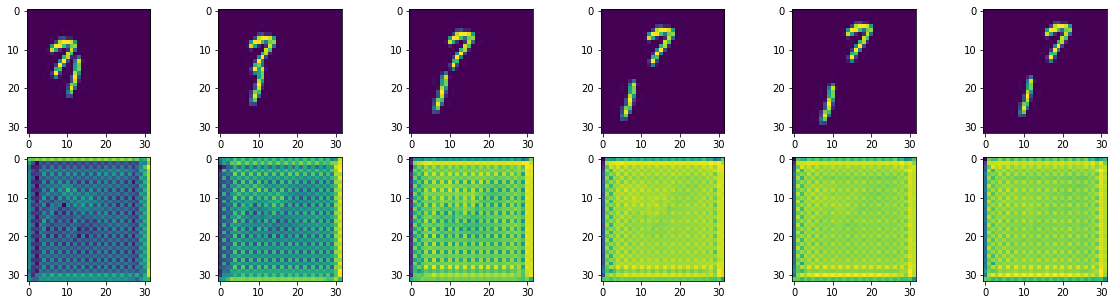

0.0009338643858834767


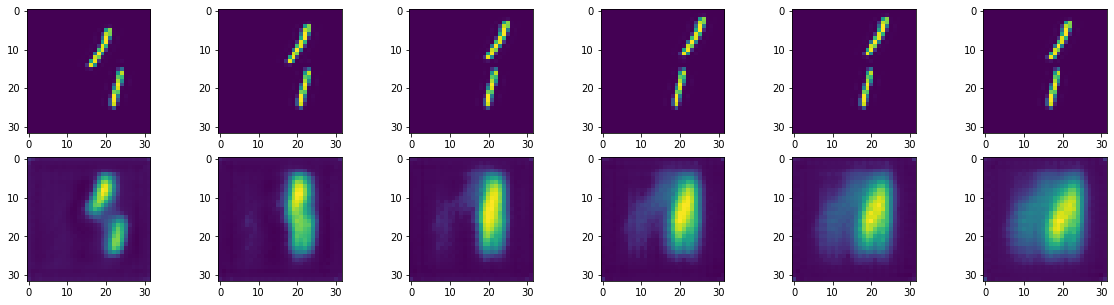

0.0008659867954177973


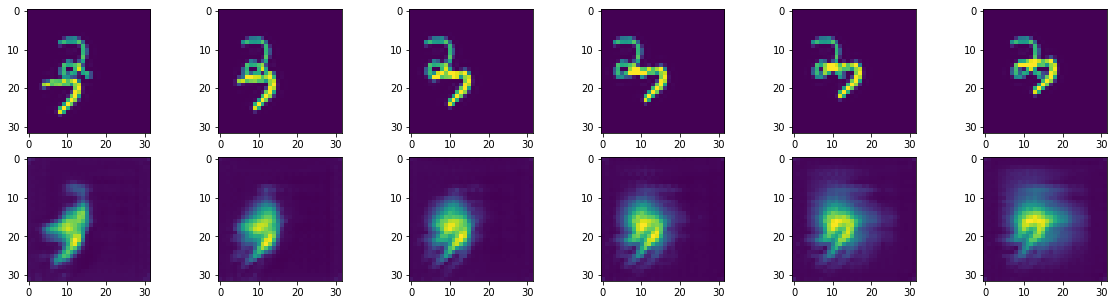

0.0008176331646188771


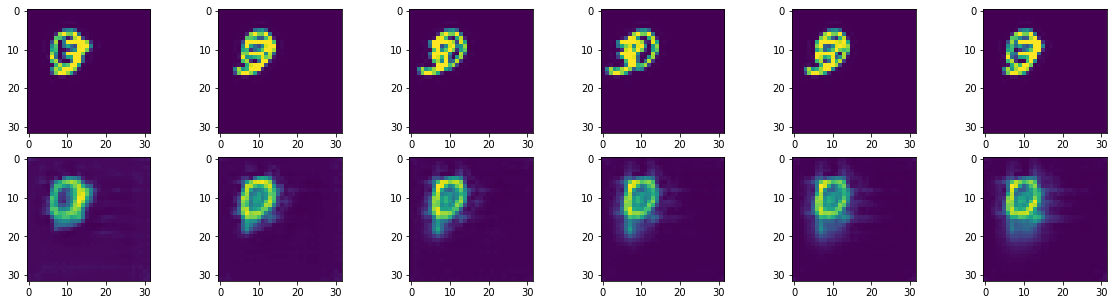

0.0007766430973559014


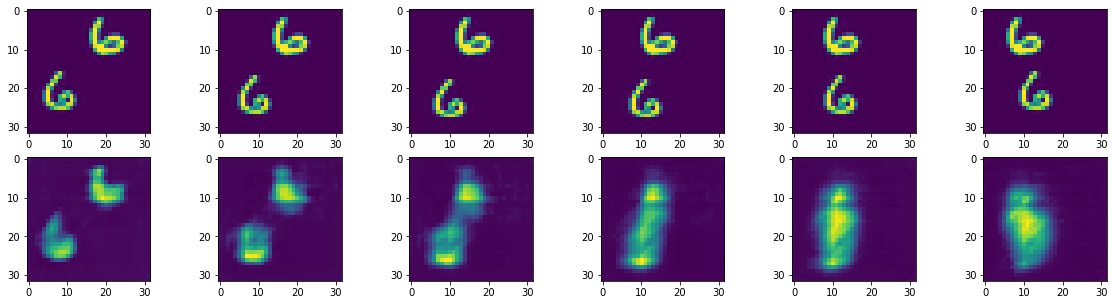

0.0007431441876147831


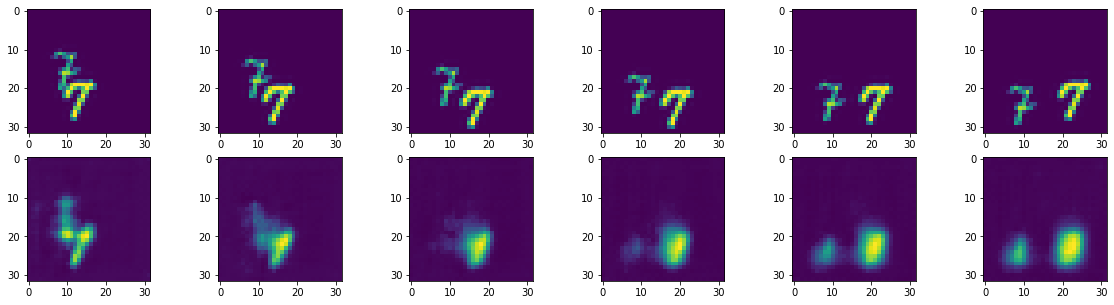

0.0007144517143028978


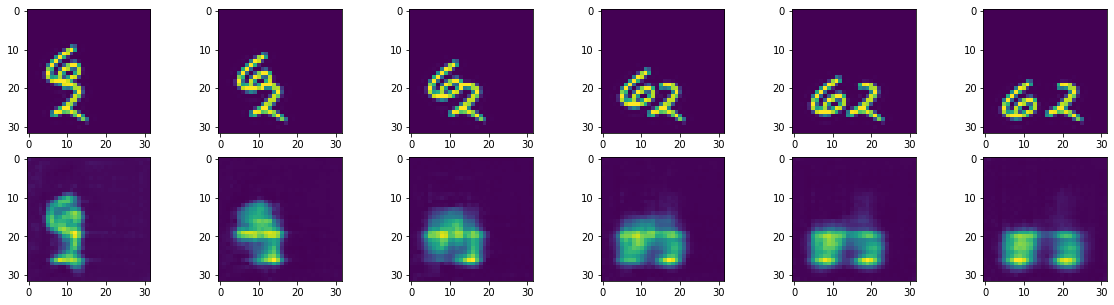

0.000688860614536939


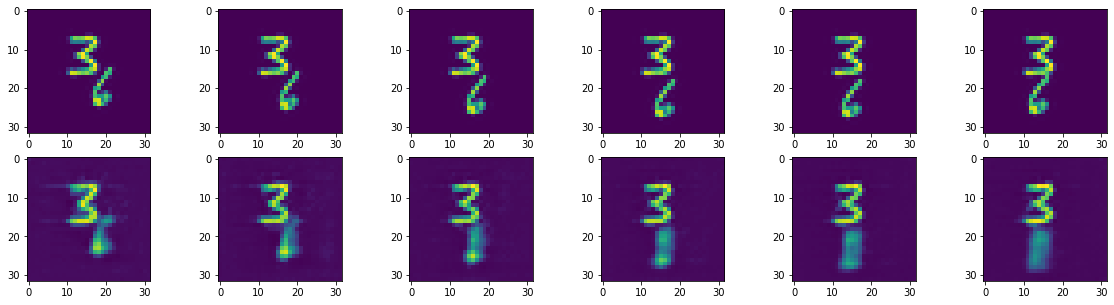

0.0006654202457221294


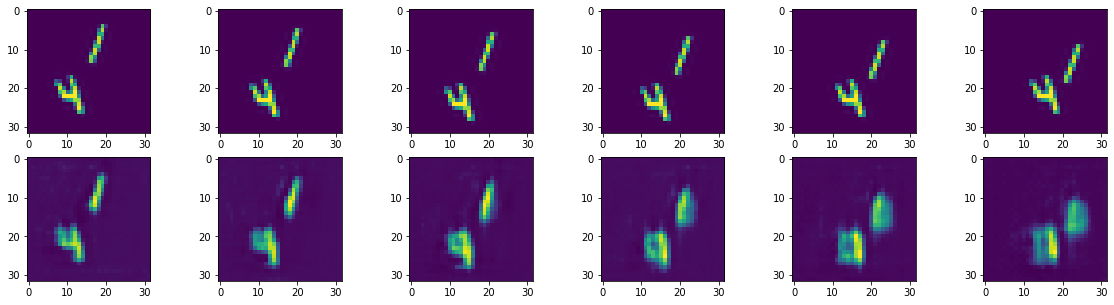

0.0006444768507050651


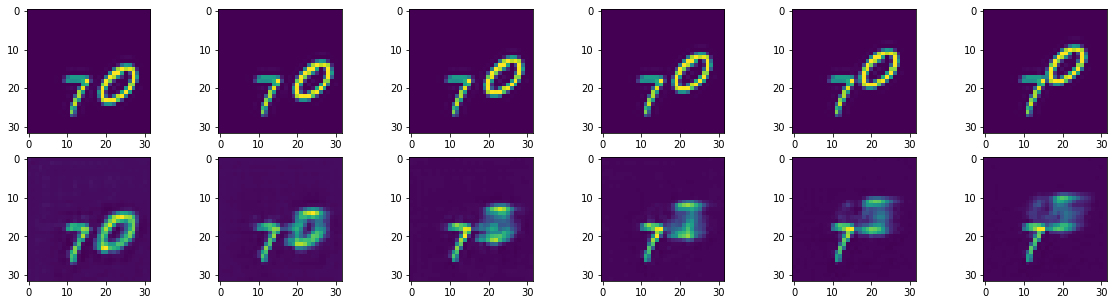

0.0006370003549919488


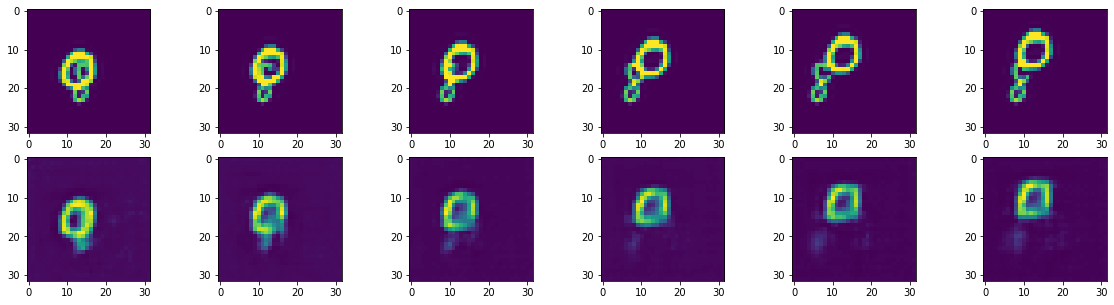

0.000618058036970085


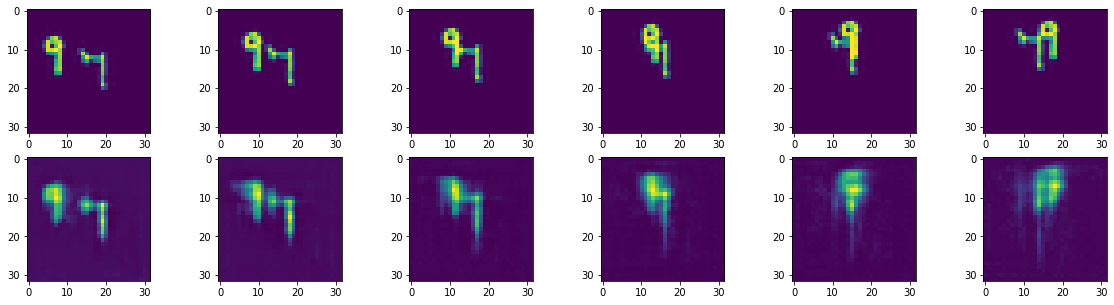

0.000600323287722788


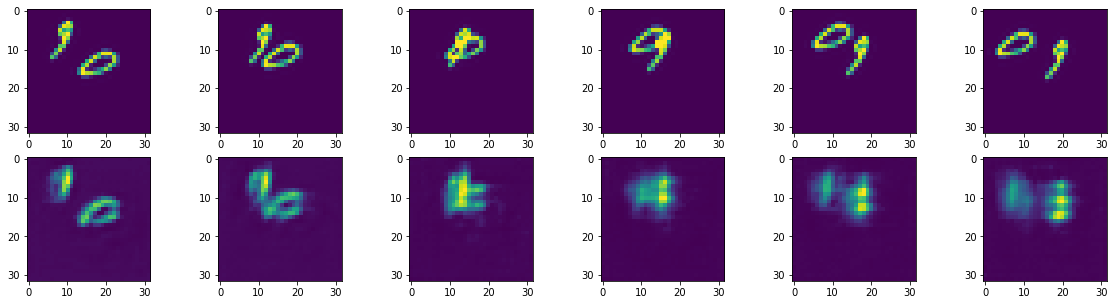

0.0005835156152604121


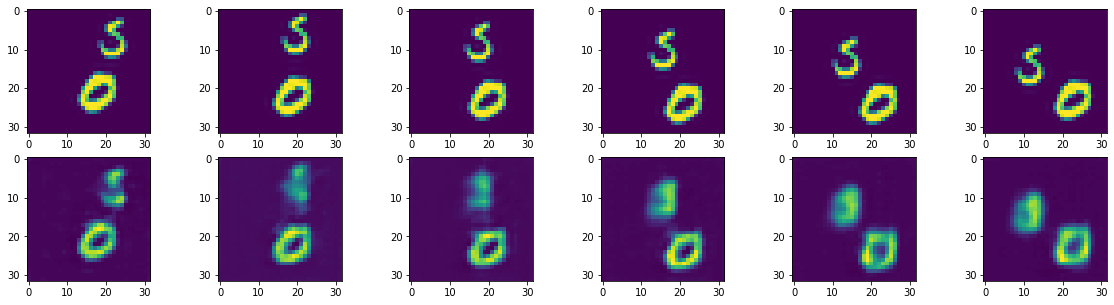

0.0005678864200532496


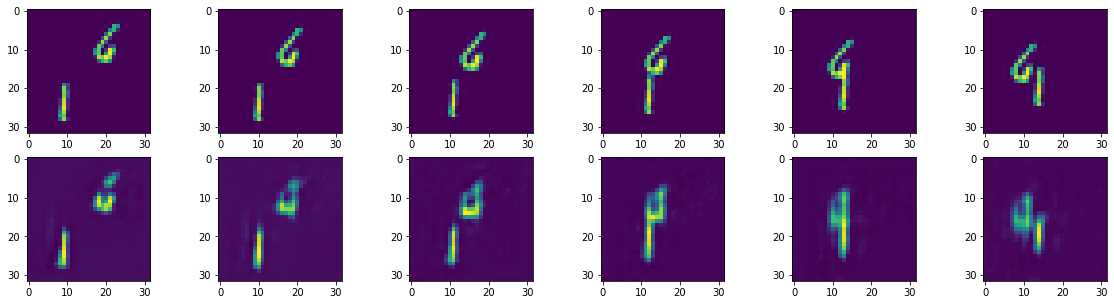

0.000553203424864584


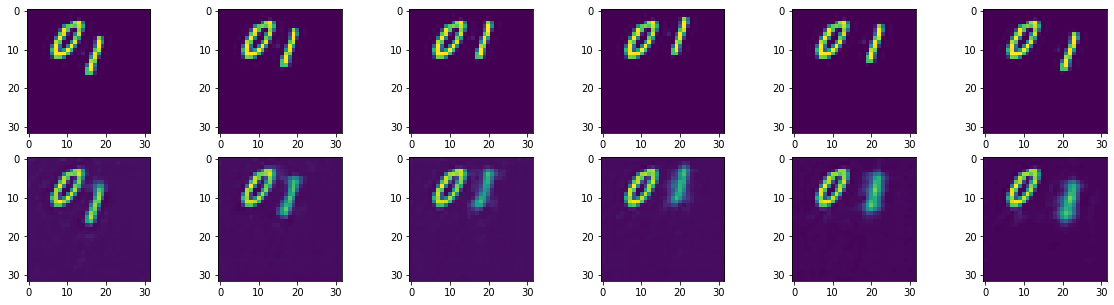

0.0005392180053211878


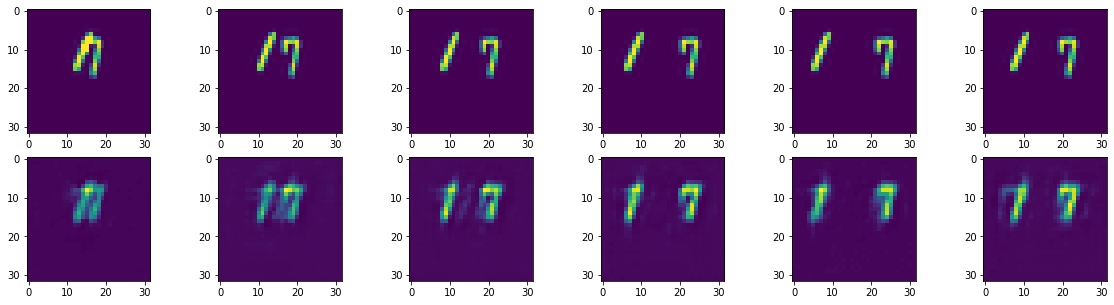

0.0005257200213551882


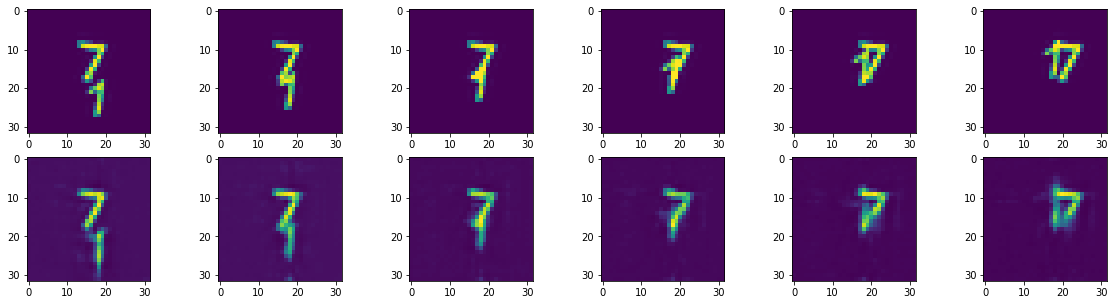

0.0005127886390205061


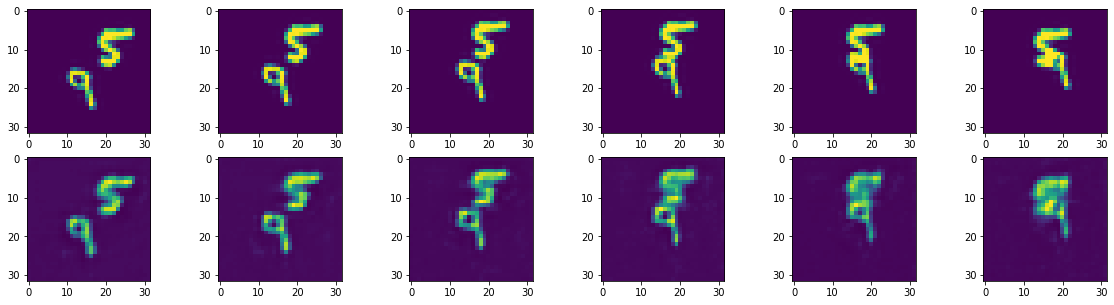

0.0005000658439654035


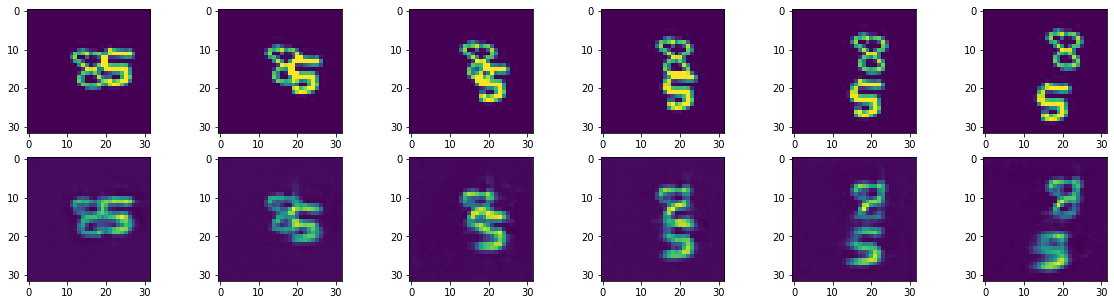

0.000495397031711586


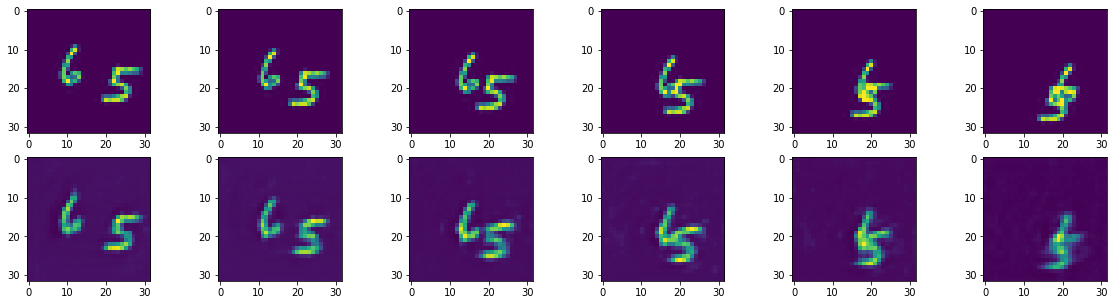

KeyboardInterrupt: ignored

In [7]:

model = Model(Encoder(), Decoder()).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
pla_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
loss_fun = nn.MSELoss().to(device) #maybe make BCE? with sigmoid output.

print_every = 200

train_losses = []
n_epochs = 10

for epoch in range(1, n_epochs + 1):
  train_loss = 0
  for batch_idx, (input, target) in enumerate(tqdm(train_loader, desc='Batch', leave=False)):
    #transforming data
    input = input.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    model.train()
    pred = model(input)
    loss = loss_fun(pred, target)
    loss_aver = loss.item() / batch_size
    train_losses.append(loss_aver)
    loss.backward()

    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
    optimizer.step()
    with torch.no_grad():
      if batch_idx % print_every == 0:
          print(np.mean(train_losses))
          fig, ax = plt.subplots(2, 6, figsize = (20,5))
          img_size = 32
          ax[0,0].imshow(target[0][0].view(img_size,img_size).detach().cpu().numpy())
          ax[0,1].imshow(target[0][1].view(img_size,img_size).detach().cpu().numpy())
          ax[0,2].imshow(target[0][2].view(img_size,img_size).detach().cpu().numpy())
          ax[0,3].imshow(target[0][3].view(img_size,img_size).detach().cpu().numpy())
          ax[0,4].imshow(target[0][4].view(img_size,img_size).detach().cpu().numpy())
          ax[0,5].imshow(target[0][5].view(img_size,img_size).detach().cpu().numpy())

          ax[1,0].imshow(pred[0][0].view(img_size,img_size).detach().cpu().numpy())
          ax[1,1].imshow(pred[0][1].view(img_size,img_size).detach().cpu().numpy())
          ax[1,2].imshow(pred[0][2].view(img_size,img_size).detach().cpu().numpy())
          ax[1,3].imshow(pred[0][3].view(img_size,img_size).detach().cpu().numpy())
          ax[1,4].imshow(pred[0][4].view(img_size,img_size).detach().cpu().numpy())
          ax[1,5].imshow(pred[0][5].view(img_size,img_size).detach().cpu().numpy())
          plt.pause(1e-6)